<a href="https://colab.research.google.com/github/arturbernardo/1brc/blob/main/obitos_cid_datasus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ipython-sql
!pip install sqlalchemy

In [ ]:
!pip install psycopg2-binary sqlalchemy

In [ ]:
pip install polars

In [19]:
import math
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2
from sqlalchemy import create_engine
from sqlalchemy import text
from getpass import getpass
from dateutil.relativedelta import relativedelta

In [ ]:
pl.Config.set_tbl_cols(-1) # mostrar todas as colunas, se desejado

# CONECTAR BASE

In [ ]:
port = 5432
database = "postgres"
user = "postgres"
host = "34.95.206.58"
password = getpass("Digite sua senha: ")
database = "postgres"

engine = create_engine(f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}")

with engine.connect() as connection:
    result = connection.execute(text("SELECT version()"))
    for row in result:
        print(row)


In [ ]:
# !curl ifconfig.me

In [ ]:
# Na base Postgres
# CREATE EXTENSION postgis;

# IMPORTAR CIDADES

In [ ]:
uri = "https://raw.githubusercontent.com/arturbernardo/municipios-brasileiros/refs/heads/main/csv/municipios.csv"
!wget -U "Mozilla" -O municipios.csv {uri}

In [75]:
path = "/content/municipios.csv"

df = pl.read_csv(path, separator=",",encoding="utf-8", null_values=["null"], truncate_ragged_lines=True)

In [76]:
df = df.to_pandas()

In [77]:
df.to_sql(
    name="municipios",
    con=engine,
    index=False
)

570

# IMPORTAR ESTADOS

In [68]:
uri = "https://raw.githubusercontent.com/arturbernardo/municipios-brasileiros/refs/heads/main/csv/estados.csv"
!wget -U "Mozilla" -O estados.csv {uri}

--2025-05-01 16:01:28--  https://raw.githubusercontent.com/arturbernardo/municipios-brasileiros/refs/heads/main/csv/estados.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1077 (1.1K) [text/plain]
Saving to: ‘estados.csv’

estados.csv         100%[===================>]   1.05K  --.-KB/s    in 0s      

2025-05-01 16:01:29 (61.6 MB/s) - ‘estados.csv’ saved [1077/1077]



In [72]:
path = "/content/estados.csv"

df = pl.read_csv(path, separator=",",encoding="utf-8", null_values=["null"], truncate_ragged_lines=True)

In [73]:
df = df.to_pandas()

In [74]:
df.to_sql(
    name="estados",
    con=engine,
    index=False
)

27

# IMPORTAR SUBCATEGORIAS DO CID

In [ ]:
uri = "https://github.com/arturbernardo/CidDataSus/raw/refs/heads/master/CIDImport/Repositorio/Resources/CID-10-SUBCATEGORIAS.CSV"
!wget -U "Mozilla" -O CID-10-SUBCATEGORIAS.CSV {uri}

In [ ]:
columns_subcat = ['SUBCAT', 'CLASSIF', 'RESTRSEXO', 'CAUSAOBITO', 'DESCRICAO', 'DESCRABREV', 'REFER', 'EXCLUIDOS']

In [44]:
path = "/content/CID-10-SUBCATEGORIAS.CSV"

sub_categorias = pl.read_csv(path, separator=";", columns=columns_subcat, encoding="latin-1", quote_char=None)

In [45]:
pandas_sub_categorias = sub_categorias.to_pandas()

In [ ]:
pandas_sub_categorias.to_sql(
    name="cid_sub_cat",       # nome da tabela no banco
    con=engine,           # conexão sqlalchemy
    index=False           # não enviar o índice do pandas como coluna
)

# IMPORTAR MORTES POR ANO

In [ ]:
# 1979 - 1995 https://diaad.s3.sa-east-1.amazonaws.com/sim/Mortalidade_Geral_1979.csv
for i in range(1979, 1996, 1):
  !wget -U "Mozilla" -O mortalidade_{str(i)}.csv https://diaad.s3.sa-east-1.amazonaws.com/sim/Mortalidade_Geral_{str(i)}.csv

In [ ]:
# 1996 - 2020 https://diaad.s3.sa-east-1.amazonaws.com/sim/Mortalidade_Geral_1979.csv
for i in range(1996, 2021, 1):
  !wget -U "Mozilla" -O mortalidade_{str(i)}.csv https://diaad.s3.sa-east-1.amazonaws.com/sim/Mortalidade_Geral_{str(i)}.csv

In [ ]:
# 2021 - Unico em padrão diferente. AWS e Titulo no formato antigo
!wget -U "Mozilla" -O mortalidade_2021.csv https://s3.sa-east-1.amazonaws.com/ckan.saude.gov.br/SIM/Mortalidade_Geral_2021.csv

In [ ]:
# https://s3.sa-east-1.amazonaws.com/ckan.saude.gov.br/SIM/DO22OPEN.csv
for i in range(22, 25, 1):
  !wget -U "Mozilla" -O mortalidade_20{str(i)}.csv https://s3.sa-east-1.amazonaws.com/ckan.saude.gov.br/SIM/DO{str(i)}OPEN.csv

In [ ]:
!ls -lha

In [24]:
!rm -Rf sample_data # remova arquivos indesejados no content ou remove eles da lista de arquivos que será processada em seguida

In [27]:
files = !ls | grep mortalidade
files

['mortalidade_1997.csv']

Cria dataframe com todos os arquivos.
Serão dezenas de milhões de registros, caso use esta abordagem.

In [ ]:
columns=["CAUSABAS", "IDADE", "SEXO", "RACACOR", "LOCOCOR", "DTNASC", "DTOBITO", "CODMUNOCOR"]

df = pl.read_csv(files[0], separator=";",encoding="latin-1", null_values=["null"], columns=columns, infer_schema=False)

for file in files[1:]:
  mortalidade = pl.read_csv(file, separator=";",encoding="latin-1", null_values=["null"], columns=columns, infer_schema=False)
  df = pl.concat([df, mortalidade], how="vertical_relaxed")

Importar separado pode ser uma estratégia melhor, caso o deseo seja analisar apenas um ano ou carregar uma base de dados.
Do Colab tive aproximadamente 2 minutos para carregar cada ano para uma base postgres na nuvem.

In [30]:
df = pl.read_csv(files[0], separator=";",encoding="latin-1", null_values=["null"], columns=columns, infer_schema=False)


RASCUNHOS: 👇

<!-- SELECT *
FROM municipios
WHERE ST_DWithin(
  location,
  ST_SetSRID(ST_MakePoint(-46.625290, -23.533773), 4326)::geography,
  15000
); -->

https://diaad.s3.sa-east-1.amazonaws.com/sim/Mortalidade_Geral+-+Estrutura.pdf

In [ ]:
# !wget -U "Mozilla" -O mortalidade_2023.csv https://s3.sa-east-1.amazonaws.com/ckan.saude.gov.br/SIM/DO23OPEN.csv

In [25]:
codigos_siglas = {
    12: "AC",
    27: "AL",
    16: "AP",
    13: "AM",
    29: "BA",
    23: "CE",
    53: "DF",
    32: "ES",
    52: "GO",
    21: "MA",
    51: "MT",
    50: "MS",
    31: "MG",
    15: "PA",
    25: "PB",
    41: "PR",
    26: "PE",
    22: "PI",
    24: "RN",
    43: "RS",
    33: "RJ",
    11: "RO",
    14: "RR",
    42: "SC",
    35: "SP",
    28: "SE",
    17: "TO"
}


Até 1955, data começa com o ano em dois digitos. yymmdd
Depois, data ddmmyyyy

até 1995, usava-se CID-9
Depois, CID10.

http://tabnet.datasus.gov.br/cgi/sim/Mortalidade_Geral_1979_1995.pdf



In [ ]:
sub_categorias

In [ ]:
files[1:]

In [ ]:
len(df)

In [17]:
mortalidade_rs = df.with_columns(
    pl.col("CODMUNOCOR").cast(pl.Utf8).str.slice(0, 2).alias("codigo_estado")
)
mortalidade_rs = mortalidade_rs.filter(pl.col("codigo_estado") == "41")

In [18]:
mortalidade_rs_causa = mortalidade_rs.join(sub_categorias, left_on="CAUSABAS", right_on="SUBCAT", how="left")

In [19]:
mortalidade_rs_causa_auto = mortalidade_rs_causa.filter(mortalidade_rs_causa['DESCRICAO'].str.contains('autoprovocada'))

In [20]:
mortalidade_rs_causa_auto = mortalidade_rs_causa_auto.with_columns(
    pl.col("DTOBITO").str.extract(r"(\d{4})$").cast(pl.Int64).alias("ANO_OBITO")
)

# mortalidade_rs_causa_auto = mortalidade_rs_causa_auto.filter(mortalidade_rs_causa_auto['DESCRICAO'].str.contains('arma de fogo'))

In [ ]:
mortalidade_rs_causa_auto

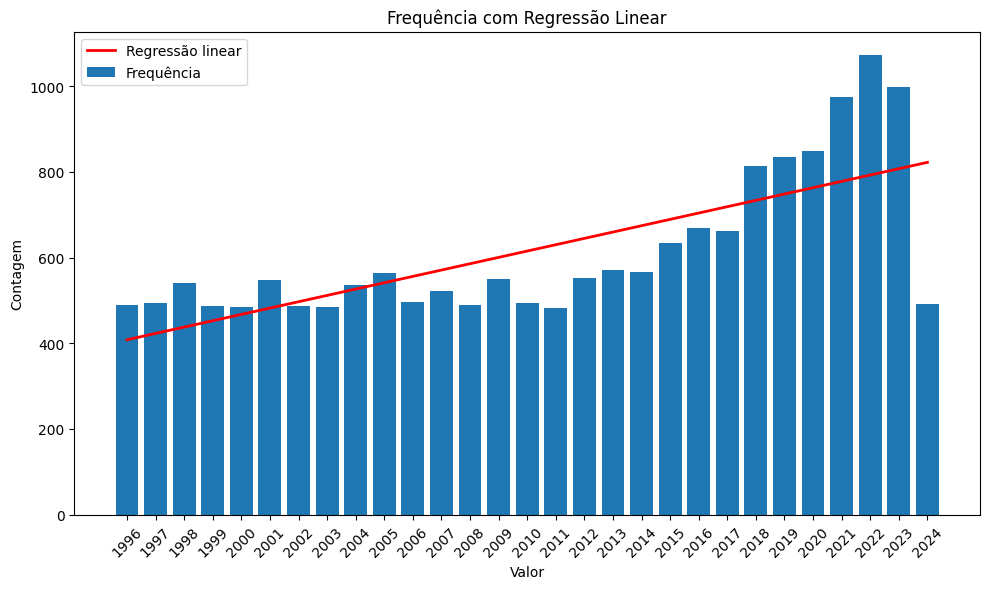

In [ ]:
contagens_pd = mortalidade_rs_causa_auto.to_pandas()


contagens = contagens_pd['ANO_OBITO'].value_counts().sort_index()

# Eixos X e Y
x = np.arange(len(contagens))  # valores do eixo x (0, 1, 2, ...)
y = contagens.values           # contagens (frequências)
labels = contagens.index       # rótulos (valores únicos da coluna)

# Regressão linear (reta: y = mx + b)
coef = np.polyfit(x, y, 1)
poly1d_fn = np.poly1d(coef)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(x, y, label='Frequência')
plt.plot(x, poly1d_fn(x), color='red', linewidth=2, label='Regressão linear')  # linha da regressão

# Rótulos e título
plt.xticks(x, labels, rotation=45)
plt.xlabel('Valor')
plt.ylabel('Contagem')
plt.title('Frequência com Regressão Linear')
plt.legend()
plt.tight_layout()
plt.show()

#######################

In [ ]:
contagens_pd = mortalidade_rs_causa_auto.to_pandas()


contagens = contagens_pd['ANO_OBITO'].value_counts().sort_index()

# Eixos X e Y
x = np.arange(len(contagens))  # valores do eixo x (0, 1, 2, ...)
y = contagens.values           # contagens (frequências)
labels = contagens.index       # rótulos (valores únicos da coluna)

# Regressão linear (reta: y = mx + b)
coef = np.polyfit(x, y, 1)
poly1d_fn = np.poly1d(coef)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(x, y, label='Frequência')
plt.plot(x, poly1d_fn(x), color='red', linewidth=2, label='Regressão linear')  # linha da regressão

# Rótulos e título
plt.xticks(x, labels, rotation=45)
plt.xlabel('Valor')
plt.ylabel('Contagem')
plt.title('Frequência com Regressão Linear')
plt.legend()
plt.tight_layout()
plt.show()

KeyError: 'ANO_OBITO'

In [ ]:
path = "/content/mortalidade_1979.csv"

mortalidade_2023 = pl.read_csv(path, separator=";",encoding="latin-1", schema_overrides={"DTNASC": pl.String, "DTOBITO": pl.String}, null_values=["null"], infer_schema=False)

In [ ]:
mortalidade_2023["CAUSABAS"]

In [ ]:
mortalidade_2023 = mortalidade_2023.with_columns(
    pl.col("DTNASC").str.strptime(pl.Date, "%d%m%Y").alias("DTNASC_CONV"),
    pl.col("DTOBITO").str.strptime(pl.Date, "%d%m%Y").alias("DTOBITO_CONV"),
)

In [ ]:
mortalidade_2023

In [ ]:
mortalidade_2023 = mortalidade_2023.with_columns(
  (
        (pl.col("DTOBITO_CONV") - pl.col("DTNASC_CONV"))
        .dt.total_days() / 365.25
    ).alias("IDADE")
)

In [ ]:
mortalidade_2023 = mortalidade_2023.with_columns(
    pl.col("CODMUNOCOR").cast(pl.Utf8).str.slice(0, 2).alias("codigo_estado")
)


In [ ]:
mortalidade_2023.collect_schema().names()

# CODMUNOCOR - cod mun local

In [ ]:
mortalidade_2023

In [ ]:
mortalidade_2023_rs = mortalidade_2023.filter(pl.col("codigo_estado") == "43")

In [ ]:
len(mortalidade_2023_rs)

93379

In [ ]:
mortalidade_2023_rs_lajeado = mortalidade_2023.filter(pl.col("CODMUNOCOR") == 431140)

In [ ]:
len(mortalidade_2023_rs_lajeado)

834

In [ ]:
mortalidade_2023_rs_lajeado

In [ ]:
# X700 até X849 e Y870
pl.Config.set_tbl_rows(100)
x = mortalidade_2023_rs_lajeado.filter(pl.col("CAUSABAS").str.starts_with("X"))
x

In [ ]:
df_x = x.select(["CAUSABAS", "IDADE", "SEXO", "RACACOR", "LOCOCOR", "DTNASC_CONV", "DTOBITO_CONV"])
df_x

In [ ]:
pl.Config.set_tbl_width_chars(200)
pl.Config.set_fmt_str_lengths(200)
df_x = df_x.join(sub_categorias, left_on="CAUSABAS", right_on="SUBCAT", how="left")

In [ ]:
# ver escolaridade e mais dados sociais

df_auto = df_x.filter(df_x['DESCRICAO'].str.contains('autoprovocada'))
print(len(df_auto))
df_auto

################

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/sim_obitos.csv', delimiter=';')

In [ ]:
df

In [ ]:
CID = df['cid_causa_basica'].unique()
CID

array(['I259', 'K703', 'Y209', ..., 'X956', 'F402', 'P229'], dtype=object)

In [ ]:
cid_subcat = pd.read_csv('/content/CID-10-SUBCATEGORIAS.CSV', encoding='latin-1', delimiter=';')

In [ ]:
cid_subcat

In [ ]:
df_index_cid = pd.read_csv('/content/sim_obitos.csv', index_col='cid_causa_basica', delimiter=';')

In [ ]:
# print(cid_subcat[cid_subcat['SUBCAT'].str.startswith('X20')])
X20 = df_index_cid[df_index_cid.index.astype(str).get_level_values('cid_causa_basica').str.startswith('X')]
X20

In [ ]:
df_filtrado = cid_subcat[cid_subcat['SUBCAT'].isin(X20.index)]
df_filtrado

In [ ]:
df_sui = df_index_cid[df_index_cid['circunstancia_obito'] == 'SUICÍDIO']
# df_sui = df_sui[df_sui['obito'].str.endswith('17')]
df_sui

In [ ]:
Z634 = df_index_cid[df_index_cid.index.astype(str).get_level_values('cid_causa_basica').str.startswith('Z634')]
Z634

,data_extracao,identificador_pessoa2,obito,nascimento,escolaridade,sexo,raca,gestacao,gravidez,tipo_obito,circunstancia_obito,obito_prematuro,obito_mulher_idade_fertil
cid_causa_basica,,,,,,,,,,,,,


In [ ]:
df_sui['nascimento_fake_day'] = '01/' + df_sui['nascimento'].astype(str)

df_sui['nasc_date'] = pd.to_datetime(df_sui['nascimento_fake_day'], errors='coerce', format="%d/%m/%Y")
df_sui['nasc_year'] = pd.DatetimeIndex(df_sui['nasc_date']).year

df_sui['obito_fake_day'] = '01/' + df_sui['obito'].astype(str)

df_sui['obito_date'] = pd.to_datetime(df_sui['obito_fake_day'], errors='coerce', format="%d/%m/%Y")
df_sui['obito_year'] = pd.DatetimeIndex(df_sui['obito_date']).year
df_sui

In [ ]:
df_sui['obito_year'].min()

2011

In [ ]:
df_2012 = df_sui[df_sui['obito'].str.endswith('12')]
df_2012

In [ ]:
df_sui['obito_year'].value_counts()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

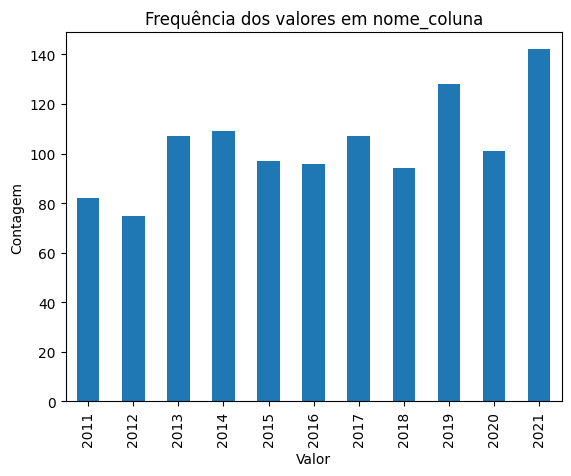

In [ ]:
contagens = df_sui['obito_year'].value_counts().sort_index()

contagens.plot(kind='bar')

# Opcional: adicionar título e rótulos
plt.title('Frequência dos valores em nome_coluna')
plt.xlabel('Valor')
plt.ylabel('Contagem')

# Mostrar o gráfico
plt.show()

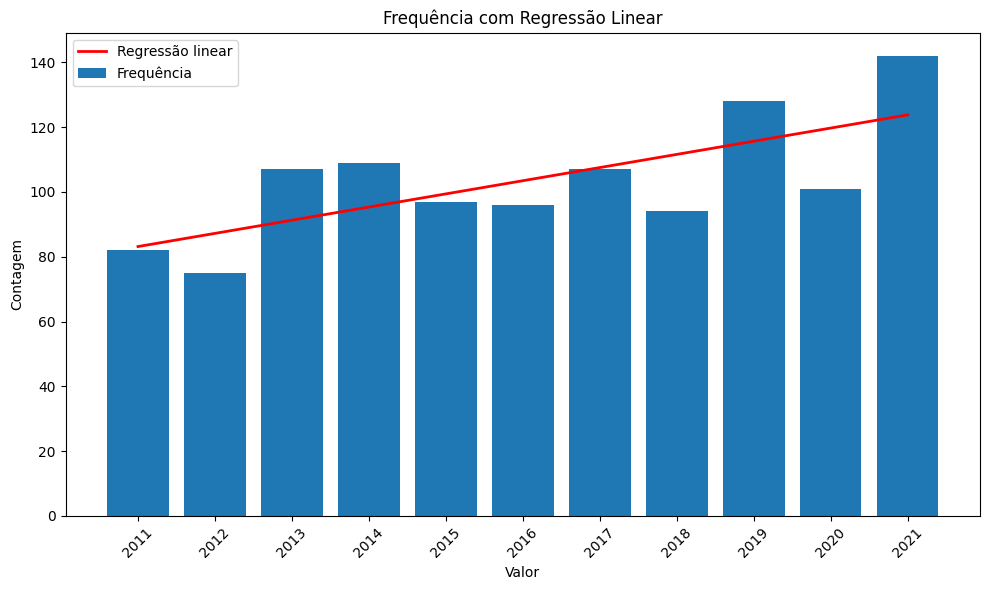

In [ ]:
# Eixos X e Y
x = np.arange(len(contagens))  # valores do eixo x (0, 1, 2, ...)
y = contagens.values           # contagens (frequências)
labels = contagens.index       # rótulos (valores únicos da coluna)

# Regressão linear (reta: y = mx + b)
coef = np.polyfit(x, y, 1)
poly1d_fn = np.poly1d(coef)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(x, y, label='Frequência')
plt.plot(x, poly1d_fn(x), color='red', linewidth=2, label='Regressão linear')  # linha da regressão

# Rótulos e título
plt.xticks(x, labels, rotation=45)
plt.xlabel('Valor')
plt.ylabel('Contagem')
plt.title('Frequência com Regressão Linear')
plt.legend()
plt.tight_layout()
plt.show()